# Import des librairies

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import shap
shap.plots.initjs()

from time import perf_counter

# Notre Score Métier

Notre entreprise souhaite pénaliser 10 fois plus les Faux Négatifs que les Faux Positifs, pour cela nous n'allons pas utiliser le f-1 score mais une variante appelé f-beta.
Le f-beta score nous permet de penaliser plus fortement la précision ou le recall afin d'insister sur ce qui est le plus important dans notre problématique

In [2]:
sqrt_10 = 10 ** (1/2)

f_beta = make_scorer(fbeta_score, beta=sqrt_10)

def fbeta_loss(y_true, y_pred):
    
    fbeta = lambda y_t, y_p : fbeta_score(y_t, y_p, beta=sqrt_10)
    
    return "F-beta", 1 - fbeta(y_true, y_pred)

In [3]:
train = pd.read_csv("data\\preprocessed_data.csv", encoding="utf-8")
train.drop('SK_ID_CURR', axis=1, inplace=True)
train.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,0,0,1,0,202500.0,406597.5,24700.5,351000.0,1,0.018801,...,False,False,False,False,True,False,True,False,1,False
1,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,3,0.003541,...,False,False,False,False,False,False,True,False,0,False
2,1,1,1,0,67500.0,135000.0,6750.0,135000.0,1,0.010032,...,False,False,False,False,False,False,False,False,0,False
3,0,0,1,0,135000.0,312682.5,29686.5,297000.0,1,0.008019,...,False,False,False,False,False,False,False,False,0,False
4,0,0,1,0,121500.0,513000.0,21865.5,513000.0,1,0.028663,...,False,False,False,False,False,False,False,False,0,False


In [4]:
binary_cols = []
numerical_cols = []

for col in train.columns:
    if train[col].nunique() <= 2:
        binary_cols.append(col)
    else:
        numerical_cols.append(col)

In [5]:
train.shape

(307511, 236)

## suppression des charactères json des noms de colonnes

In [6]:
import re

train.columns = [re.sub(r'[^A-Za-z0-9 _]+', '', col) for col in train.columns]

In [7]:
na_percent = train.isna().mean().reset_index()
na_percent.columns = ["col_name", "na_percent"]
na_percent.sort_values(by="na_percent", ascending=False).head(25)

,col_name,na_percent
66,COMMONAREA_MEDI,0.698723
52,COMMONAREA_MODE,0.698723
38,COMMONAREA_AVG,0.698723
74,NONLIVINGAPARTMENTS_MEDI,0.694330
60,NONLIVINGAPARTMENTS_MODE,0.694330
46,NONLIVINGAPARTMENTS_AVG,0.694330
72,LIVINGAPARTMENTS_MEDI,0.683550
58,LIVINGAPARTMENTS_MODE,0.683550
44,LIVINGAPARTMENTS_AVG,0.683550
70,FLOORSMIN_MEDI,0.678486


In [8]:
imputer = SimpleImputer(strategy='median').set_output(transform='pandas')

train = imputer.fit_transform(train)

train.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,WALLSMATERIAL_MODE_Stone brick,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,1.0,0.018801,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,3.0,0.003541,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,1.0,0.010032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,1.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,1.0,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
y = train['TARGET']
X = train.drop('TARGET', axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.25,
                                                   random_state=42,
                                                   stratify=y)

# Equilibrage des données

Sans rebalancer le dataset, plusieurs modèles prédisent uniquement la classes majoritaire.

Plusieurs solutions s'offrent à nous pour corriger ce problème:
* Changement du threshold à partir duquel le label change
* Indiquer un poids pour les catégories
* Resampling du dataset:
    * Undersampling: Réduire le nombre d'échantillons de la classe majoritaire pour que les classes aient un nombre égal
    * Oversampling: Créer des échantillons artificielle de la classe minoritaire pour que les classes aient un nombre égal

## Changement du poids des labels

Une méthode simple pour gérer le deséquilibre des classes est de donner plus de poids à la classe minoritaire afin que cela compense pour le plus faible nombre d'individus

In [11]:
scaler = RobustScaler().set_output(transform='pandas')

In [12]:
dummy = Pipeline([
    ('scaler', scaler),
    ('dummy', DummyClassifier())
])

In [13]:
lgbm = Pipeline([
    ('scaler', scaler),
    ('lgbm', LGBMClassifier(class_weight='balanced'))
])

In [14]:
logreg = Pipeline([
    ('scaler', scaler),
    ('logreg', LogisticRegression(class_weight='balanced'))   
])

In [15]:
def run_cross_validation(model, X, y, scoring={'f_beta': f_beta, 'roc_auc': 'roc_auc'}):
    from sklearn.model_selection import cross_validate
    from time import perf_counter
    
    start = perf_counter()
    scores = cross_validate(model,
                           X=X,
                           y=y,
                           cv=3,
                           n_jobs=-1,
                           scoring=scoring)
    
    end = perf_counter()
    
    print(f"it tooks {end-start:.2f} seconds to evaluate the model")
    print(scores)
    
    for score in scores:
        scores[score] = round(np.mean(scores[score]), 3)
    
    return scores

In [16]:
score_col = ['model', 'resampling', 'fit_time', 'test_f_beta', 'test_roc_auc']
scores_df = pd.DataFrame(columns=score_col)
scores_df

,model,resampling,fit_time,test_f_beta,test_roc_auc


In [17]:
def add_scores(df, scores, model, resampling_method):
    scores['model'] = model
    scores['resampling'] = resampling_method
    
    df.loc[df.shape[0]] = scores
    
    return df

In [18]:
scores = run_cross_validation(dummy, X_train, y_train)

add_scores(scores_df, scores, 'dummy', 'balancing')

it tooks 10.12 seconds to evaluate the model
{'fit_time': array([3.30502844, 3.33799744, 3.26987219]), 'score_time': array([0.72234797, 0.69316983, 0.6700089 ]), 'test_f_beta': array([0., 0., 0.]), 'test_roc_auc': array([0.5, 0.5, 0.5])}


,model,resampling,fit_time,test_f_beta,test_roc_auc
0,logreg,balancing,3.304,0.0,0.5


In [19]:
scores = run_cross_validation(logreg, X_train, y_train)

add_scores(scores_df, scores, 'logreg', 'balancing')

it tooks 27.76 seconds to evaluate the model
{'fit_time': array([20.00959206, 20.03594971, 20.63558888]), 'score_time': array([0.74749112, 0.74210024, 0.86325431]), 'test_f_beta': array([0.50994782, 0.50668466, 0.51217702]), 'test_roc_auc': array([0.73421523, 0.7279964 , 0.73871099])}


,model,resampling,fit_time,test_f_beta,test_roc_auc
0,logreg,balancing,3.304,0.00,0.500
1,logreg,balancing,20.227,0.51,0.734


In [20]:
scores = run_cross_validation(lgbm, X_train, y_train)

add_scores(scores_df, scores, 'lgbm', 'balancing')

it tooks 20.99 seconds to evaluate the model
{'fit_time': array([13.7799058 , 13.76967192, 12.14308596]), 'score_time': array([2.16575003, 2.21831083, 2.81950808]), 'test_f_beta': array([0.51876352, 0.53006699, 0.51586331]), 'test_roc_auc': array([0.74995183, 0.75689069, 0.75335146])}


,model,resampling,fit_time,test_f_beta,test_roc_auc
0,logreg,balancing,3.304,0.000,0.500
1,logreg,balancing,20.227,0.510,0.734
2,lgbm,balancing,13.231,0.522,0.753


## Undersampling

In [21]:
dummy = Pipeline([
    ('resampler', RandomUnderSampler()),
    ('scaler', scaler),
    ('dummy', DummyClassifier())   
])

In [22]:
logreg = Pipeline([
    ('resampler', RandomUnderSampler()),
    ('scaler', scaler),
    ('logreg', LogisticRegression())   
])

In [23]:
lgbm= Pipeline([
    ('resampler', RandomUnderSampler()),
    ('scaler', scaler),
    ('lgbm', LGBMClassifier())
])

In [24]:
scores = run_cross_validation(dummy, X_train, y_train)

add_scores(scores_df, scores, 'dummy', 'Undersampling')

it tooks 3.95 seconds to evaluate the model
{'fit_time': array([1.57137394, 1.54311585, 1.55001783]), 'score_time': array([0.60076141, 0.61605263, 0.59008265]), 'test_f_beta': array([0., 0., 0.]), 'test_roc_auc': array([0.5, 0.5, 0.5])}


,model,resampling,fit_time,test_f_beta,test_roc_auc
0,logreg,balancing,3.304,0.000,0.500
1,logreg,balancing,20.227,0.510,0.734
2,lgbm,balancing,13.231,0.522,0.753
3,dummy,Undersampling,1.555,0.000,0.500


In [25]:
scores = run_cross_validation(logreg, X_train, y_train)

add_scores(scores_df, scores, 'logreg', 'Undersampling')

it tooks 6.19 seconds to evaluate the model
{'fit_time': array([4.02857614, 4.11575437, 4.15033674]), 'score_time': array([0.65490413, 0.61853385, 0.60253406]), 'test_f_beta': array([0.51534933, 0.52523454, 0.51840539]), 'test_roc_auc': array([0.73634777, 0.7456699 , 0.74073218])}


,model,resampling,fit_time,test_f_beta,test_roc_auc
0,logreg,balancing,3.304,0.000,0.500
1,logreg,balancing,20.227,0.510,0.734
2,lgbm,balancing,13.231,0.522,0.753
3,dummy,Undersampling,1.555,0.000,0.500
4,logreg,Undersampling,4.098,0.520,0.741


In [26]:
scores = run_cross_validation(lgbm, X_train, y_train)

add_scores(scores_df, scores, 'lgbm', 'Undersampling')

it tooks 14.34 seconds to evaluate the model
{'fit_time': array([7.18957543, 9.02352285, 7.04694843]), 'score_time': array([3.71284628, 3.86272836, 4.05290222]), 'test_f_beta': array([0.52721173, 0.5313172 , 0.52376203]), 'test_roc_auc': array([0.74685391, 0.75182221, 0.75003543])}


,model,resampling,fit_time,test_f_beta,test_roc_auc
0,logreg,balancing,3.304,0.000,0.500
1,logreg,balancing,20.227,0.510,0.734
2,lgbm,balancing,13.231,0.522,0.753
3,dummy,Undersampling,1.555,0.000,0.500
4,logreg,Undersampling,4.098,0.520,0.741
5,lgbm,Undersampling,7.753,0.527,0.750


## Oversampling

In [27]:
dummy = Pipeline([
    ('resampler', ADASYN()),
    ('scaler', scaler),
    ('logreg', DummyClassifier())   
])

In [28]:
logreg = Pipeline([
    ('resampler', ADASYN()),
    ('scaler', scaler),
    ('logreg', LogisticRegression())   
])

In [29]:
lgbm = Pipeline([
    ('resampler', ADASYN()),
    ('scaler', scaler),
    ('lgbm', LGBMClassifier())
])

In [30]:
scores = run_cross_validation(dummy, X_train, y_train)

add_scores(scores_df, scores, 'dummy', 'Oversampling')

it tooks 144.51 seconds to evaluate the model
{'fit_time': array([142.1389184 , 141.758986  , 142.22618961]), 'score_time': array([0.60681748, 0.64057803, 0.57524204]), 'test_f_beta': array([0.49134146, 0.49138527, 0.491345  ]), 'test_roc_auc': array([0.5, 0.5, 0.5])}


,model,resampling,fit_time,test_f_beta,test_roc_auc
0,logreg,balancing,3.304,0.000,0.500
1,logreg,balancing,20.227,0.510,0.734
2,lgbm,balancing,13.231,0.522,0.753
3,dummy,Undersampling,1.555,0.000,0.500
4,logreg,Undersampling,4.098,0.520,0.741
5,lgbm,Undersampling,7.753,0.527,0.750
6,dummy,Oversampling,142.041,0.491,0.500


In [31]:
scores = run_cross_validation(logreg, X_train, y_train)

add_scores(scores_df, scores, 'logreg', 'Oversampling')

it tooks 141.99 seconds to evaluate the model
{'fit_time': array([140.09673858, 138.1473546 , 139.38538623]), 'score_time': array([0.61725354, 0.86636829, 0.71286345]), 'test_f_beta': array([0.49212517, 0.52064329, 0.48203223]), 'test_roc_auc': array([0.71956231, 0.73635853, 0.69708182])}


,model,resampling,fit_time,test_f_beta,test_roc_auc
0,logreg,balancing,3.304,0.000,0.500
1,logreg,balancing,20.227,0.510,0.734
2,lgbm,balancing,13.231,0.522,0.753
3,dummy,Undersampling,1.555,0.000,0.500
4,logreg,Undersampling,4.098,0.520,0.741
5,lgbm,Undersampling,7.753,0.527,0.750
6,dummy,Oversampling,142.041,0.491,0.500
7,logreg,Oversampling,139.210,0.498,0.718


In [32]:
scores = run_cross_validation(lgbm, X_train, y_train)

add_scores(scores_df, scores, 'lgbm', 'Oversampling')

it tooks 151.33 seconds to evaluate the model
{'fit_time': array([140.80445981, 145.5306561 , 142.47658086]), 'score_time': array([4.76089931, 4.50680733, 5.09956121]), 'test_f_beta': array([0.01379022, 0.01644034, 0.013439  ]), 'test_roc_auc': array([0.74750828, 0.75510636, 0.75248618])}


,model,resampling,fit_time,test_f_beta,test_roc_auc
0,logreg,balancing,3.304,0.000,0.500
1,logreg,balancing,20.227,0.510,0.734
2,lgbm,balancing,13.231,0.522,0.753
3,dummy,Undersampling,1.555,0.000,0.500
4,logreg,Undersampling,4.098,0.520,0.741
5,lgbm,Undersampling,7.753,0.527,0.750
6,dummy,Oversampling,142.041,0.491,0.500
7,logreg,Oversampling,139.210,0.498,0.718
8,lgbm,Oversampling,142.937,0.015,0.752


## comparaison des techniques de resampling

In [33]:
scores_df

,model,resampling,fit_time,test_f_beta,test_roc_auc
0,logreg,balancing,3.304,0.000,0.500
1,logreg,balancing,20.227,0.510,0.734
2,lgbm,balancing,13.231,0.522,0.753
3,dummy,Undersampling,1.555,0.000,0.500
4,logreg,Undersampling,4.098,0.520,0.741
5,lgbm,Undersampling,7.753,0.527,0.750
6,dummy,Oversampling,142.041,0.491,0.500
7,logreg,Oversampling,139.210,0.498,0.718
8,lgbm,Oversampling,142.937,0.015,0.752


Comme nous pouvons le voir, les meilleurs scores ont été obtenus en ajoutant de poids pour nos deux catégories et en réduisant la classe majoritaire pour réequilibrer les classes.

Augmenter le nombre d'échantillon de la classe minoritaire avec ADASYN à eu deux inconvenients. Un f-beta très faible pour notre modèle utilisant LGBM, et un temps d'entrainement fortement augmenté.

Comme les deux premières techniques ont des scores similaires, nous allons utiliser l'undersampling car cela nous permet d'entrainer notre modèle plus rapidement.

# Recherche sur grille des meilleurs paramètres

In [34]:
logreg = Pipeline([
    ('resampler', RandomUnderSampler()),
    ('scaler', scaler),
    ('logreg', LogisticRegression())   
])

In [35]:
lgbm= Pipeline([
    ('resampler', RandomUnderSampler()),
    ('scaler', scaler),
    ('lgbm', LGBMClassifier())
])

In [36]:
params = {
    "logreg__C": [0.01, 0.1, 1],
    "logreg__penalty" : ["l2", "l1"],
    "logreg__max_iter" : [100,],
    "logreg__solver": ['liblinear']
}
cv = GridSearchCV(logreg, param_grid=params, scoring=f_beta, cv=3, n_jobs=-1, verbose=2)

cv.fit(X, y)

cv.cv_results_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


{'mean_fit_time': array([ 8.62246823,  6.17490959, 11.98330768,  9.60633365, 15.81120221,
        14.97883868]),
 'std_fit_time': array([0.65555224, 0.50800473, 1.69983943, 1.8181518 , 0.66640858,
        0.1317029 ]),
 'mean_score_time': array([0.95064465, 1.09674454, 1.13908879, 1.28998288, 0.81392845,
        0.66613221]),
 'std_score_time': array([0.07587213, 0.18889226, 0.09028745, 0.21082786, 0.10439336,
        0.06447326]),
 'param_logreg__C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1, 1],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_logreg__max_iter': masked_array(data=[100, 100, 100, 100, 100, 100],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_logreg__penalty': masked_array(data=['l2', 'l1', 'l2', 'l1', 'l2', 'l1'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=o

In [37]:
cv.best_params_

{'logreg__C': 1,
 'logreg__max_iter': 100,
 'logreg__penalty': 'l1',
 'logreg__solver': 'liblinear'}

In [38]:
params = {
    "lgbm__learning_rate": [0.05, 0.08, 0.1, 0.12, 0.15],
    "lgbm__n_estimators": [50, 100, 150]
}

cv = GridSearchCV(lgbm, param_grid=params, scoring=f_beta, cv=3, n_jobs=-1, verbose=2)

cv.fit(X, y)

cv.cv_results_

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 24825, number of negative: 24825
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10848
[LightGBM] [Info] Number of data points in the train set: 49650, number of used features: 218
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


{'mean_fit_time': array([21.68581613, 39.99009196, 46.23840181, 14.79463776, 30.42563192,
        44.99866215, 22.33505607, 36.20729963, 39.74311582, 13.02428126,
        24.2668252 , 31.79119611, 12.57114426, 20.72370688, 14.65151389]),
 'std_fit_time': array([0.5269499 , 1.07290649, 6.02765175, 4.52535353, 8.39970431,
        0.45970699, 2.05821002, 2.32090008, 3.49086879, 3.06577784,
        1.0071215 , 3.71722015, 1.50110647, 1.81822109, 2.67239992]),
 'mean_score_time': array([2.97671803, 3.08261418, 2.90488696, 1.23693601, 3.63578669,
        3.31650726, 1.70678576, 1.71608774, 2.28557897, 1.51881631,
        2.14819582, 1.79072634, 1.60268799, 1.57529688, 1.92326983]),
 'std_score_time': array([0.08767694, 0.19130304, 0.65659816, 0.02507444, 0.83913148,
        0.52006469, 0.20239621, 0.2939153 , 0.5131502 , 0.22690014,
        0.33095811, 0.16688861, 0.4775179 , 0.12388244, 0.20951778]),
 'param_lgbm__learning_rate': masked_array(data=[0.05, 0.05, 0.05, 0.08, 0.08, 0.08, 0.1, 0

In [39]:
cv.best_params_

{'lgbm__learning_rate': 0.1, 'lgbm__n_estimators': 100}

In [40]:
params = {key.replace("lgbm__", ""):value for key,value in cv.best_params_.items()}

lgbm['lgbm'].set_params(learning_rate=params["learning_rate"])
lgbm['lgbm'].set_params(n_estimators=params["n_estimators"])
lgbm

Pipeline(steps=[('resampler', RandomUnderSampler()), ('scaler', RobustScaler()),
                ('lgbm', LGBMClassifier())])

In [41]:
lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 18619, number of negative: 18619
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10735
[LightGBM] [Info] Number of data points in the train set: 37238, number of used features: 215
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


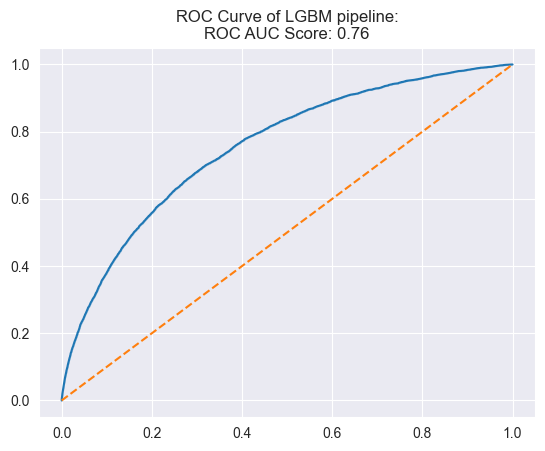

In [42]:
roc_auc = round(roc_auc_score(y_test, y_prob), 2)
fpr, tpr, _ = roc_curve(y_test, y_prob)

sns.lineplot(x=fpr, y=tpr, markers='o')
sns.lineplot(x=[0,1], y=[0,1], linestyle='--')
plt.title(f"ROC Curve of LGBM pipeline:\nROC AUC Score: {roc_auc}");

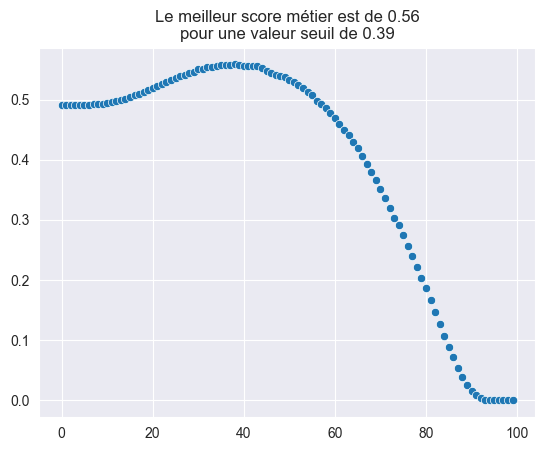

In [43]:
scores = []
for i in range(0, 100):
    y_thresh = [1 if y > (i/100) else 0 for y in y_prob]
    
    scores.append(fbeta_score(y_test, y_thresh, beta=sqrt_10))

best_idx = (np.argmax(scores) + 1) / 100
best_fbeta = max(scores)
    
title = f"Le meilleur score métier est de {best_fbeta:.2f}\npour une valeur seuil de {best_idx}"
    
sns.scatterplot(x=range(0,100), y=scores)
plt.title(title);

# Explication du modèle avec SHAP

In [44]:
explainer = shap.TreeExplainer(lgbm['lgbm'])

X_test = lgbm['scaler'].transform(X_test)

shap_values = explainer(X_test)

In [45]:
shap.force_plot(
    explainer.expected_value, shap_values.values[1, :], X_test.iloc[0, :]
)

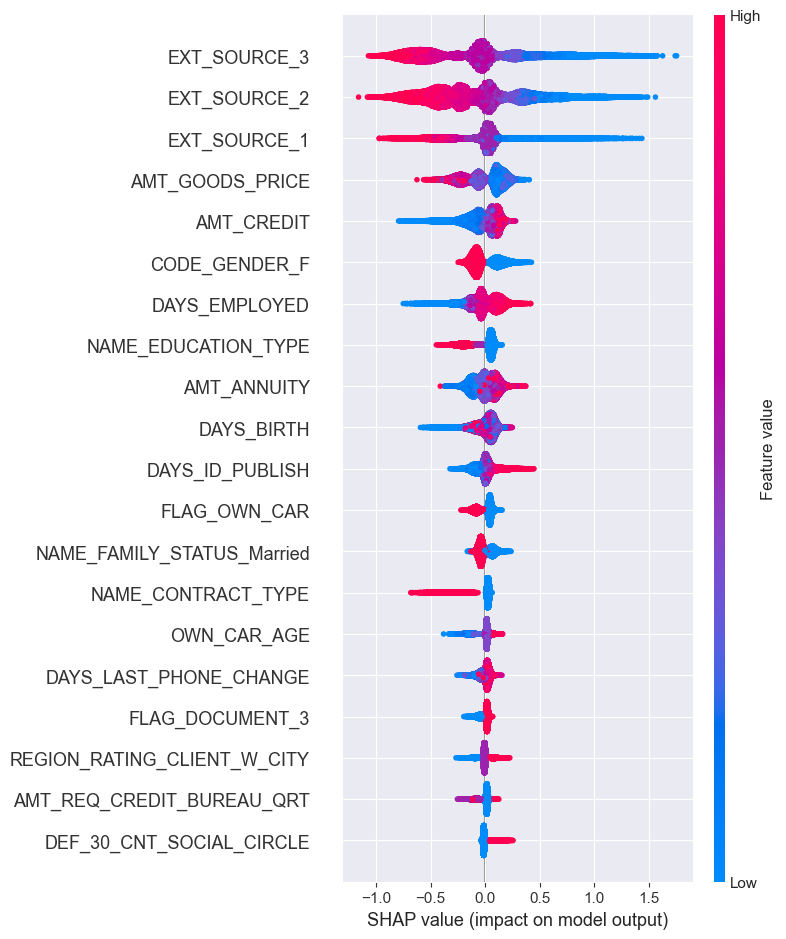

In [46]:
shap.summary_plot(shap_values, X_test)

## Explication de feature locale

Pour cet exemple nous allons prendre un échantillon de nos données au hasard pour voir l'impact de chaque feature sur la prédiction.

Si nous le souhaitons, nous pouvons enregistrer le modèle entraîné dans un ficher pickle pour créer un script nous permettant de choisir un point dans notre jeu de donnée et de voir l'influence de chaque variable sur la prédiction

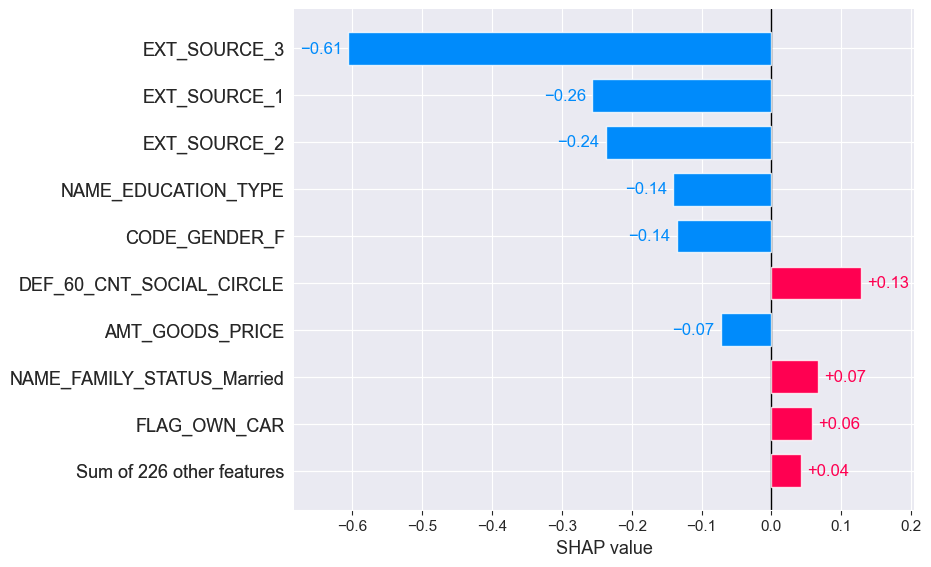

In [54]:
import random

i = random.randint(0, X_test.shape[0])

shap.plots.bar(shap_values[i], show_data=False)

In [55]:
y_pred =  [1 if y > 0.39 else 0 for y in y_prob]

prediction = y_pred[i]

if prediction == 1:
    output = "client à risque"
    
else:
    output = "client sûr"

print(f"L'individu numéro {i} est considéré comme un {output}")

L'individu numéro 28364 est considéré comme un client sûr
